In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pandas_datareader import data as pdr
from scipy import stats
from scipy.stats import t

AAPL = pd.read_csv('AAPL.csv')
AAPL = AAPL.drop(['PERMNO'], 1)
AAPL['date'] = pd.to_datetime(AAPL.date, format = '%d/%m/%Y')

AAPL_plot = AAPL.dropna(axis = 0, subset = ['DIVAMT'])

hw_start = AAPL[AAPL['date'] =='2019-01-02'].index[0]
AAPL
hw_end = AAPL[AAPL['date'] =='2021-12-31'].index[0]
AAPL = AAPL[hw_start:hw_end]

AAPL_plot2 = AAPL.dropna(axis = 0, subset = ['DIVAMT'])
wrong_d = AAPL_plot2[AAPL_plot2['DISTCD'] != 1232].index[0]
AAPL_plot2.drop(index = wrong_d, inplace = True)

start = '2019-01-02'
end = '2021-12-31'
drange=pd.DataFrame(index=AAPL.index)

rf=pdr.get_data_fred("DTB4WK", start=start, end=end)
rf= rf/100
rf.rename(columns={"DTB4WK":"rf_rate"}, inplace=True)

AAPL = AAPL.set_index(AAPL['date'])
AAPL = pd.concat([AAPL, rf], join = 'inner', axis = 1)
AAPL.drop(columns = 'date', inplace = True)

for i in range(len(AAPL)):
    if math.isnan(AAPL['rf_rate'][i]):
        AAPL['rf_rate'][i] = AAPL['rf_rate'][i-1]

<ipython-input-1-abe89b25d00c>:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  AAPL = AAPL.drop(['PERMNO'], 1)
/Users/ciel/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-1-abe89b25d00c>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AAPL['rf_rate'][i] = AAPL['rf_rate'][i-1]


## 1. Graph showing the \$dividends versus calendar time 

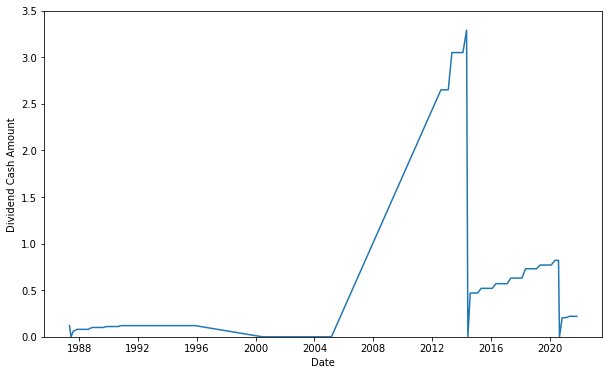

In [2]:
plt.figure(figsize = (10, 6))
plt.plot(AAPL_plot[['date']], AAPL_plot[['DIVAMT']])
plt.xlabel('Date')
plt.ylabel('Dividend Cash Amount')
#plt.grid()
#plt.title('APPLE Dividends Amount')
plt.ylim(0, 3.5)
plt.show()

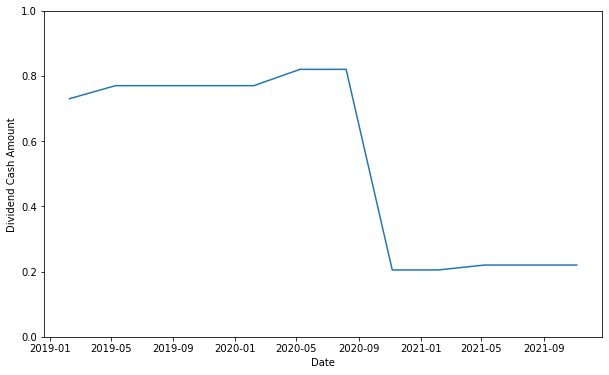

In [3]:
plt.figure(figsize = (10, 6))
plt.plot(AAPL_plot2[['date']], AAPL_plot2[['DIVAMT']])
plt.xlabel('Date')
plt.ylabel('Dividend Cash Amount')
#plt.grid()
#plt.title('APPLE Dividends Amount from 2019 to 2021')
plt.ylim(0, 1)
plt.show()

## 2.  Estimate Windows
Choosing declaration date 29/10/2020 -- suddenly drop dividend amount

In [4]:
AAPL = AAPL.reset_index()
AAPL.rename(columns = {'index': 'date'}, inplace = True)

est_period_end = AAPL[AAPL['date'] == '29/10/2020'].index[0]-11
est_period_start = AAPL[AAPL['date'] == '29/04/2020'].index[0] - 11

AAPL_ols = AAPL[['date', 'RET', 'vwretd', 'rf_rate']][est_period_start: est_period_end+1]

AAPL_ols['RET'] = np.array(AAPL_ols['RET'], dtype = float)

##########Define Function For OLS Regression##########
def OLS(x, Y):
    X = sm.add_constant(x.dropna())
    MODEL = sm.OLS(Y.dropna(), X).fit()
    return MODEL.params, str(MODEL.summary())

########## A. Market Model ##########

paramsM, olsM = OLS(AAPL_ols['vwretd'], AAPL_ols["RET"])

print(olsM)

                            OLS Regression Results                            
Dep. Variable:                    RET   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                     86.54
Date:                Wed, 13 Apr 2022   Prob (F-statistic):           5.12e-16
Time:                        09:10:47   Log-Likelihood:                 329.99
No. Observations:                 129   AIC:                            -656.0
Df Residuals:                     127   BIC:                            -650.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.002      1.420      0.1

/Users/ciel/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


#### AR & CAR test

In [6]:
def obtainARTest(df, AR, var):
    test = pd.DataFrame(index = df.index)
    L = len(df['RET'])
    #var = sum(AR.apply(lambda x: x*x)) / (L - 2)
    AR_stat = AR / math.sqrt(var)
    test['AR'] = AR
    test['AR-stat'] = AR_stat.apply(lambda x: round(x, 4))
    
    test['AR_sig_level'] = test['AR-stat'].apply(lambda x: '**' if abs(x) > t2 else '*' if abs(x) > t1 else ' ')
    test['AR-stat'] = test['AR-stat'].astype(str).add(test['AR_sig_level'])
    
    test['CAR'] = AR.cumsum()
    CAR_stat = []
    for k in range(L):
        period = test.index[k] - test.index[0] + 1
        car_t = test['CAR'][test.index[k]]
        CAR_stat.append(round(car_t / math.sqrt(period * var), 4))
    test['CAR_stat'] = CAR_stat
    test['CAR_sig_level'] = test['CAR_stat'].apply(lambda x: '**' if abs(x) > t2 else '*' if abs(x) > t1 else ' ')
    test['CAR_stat'] = test['CAR_stat'].astype(str).add(test['CAR_sig_level'])
    return test[['AR-stat']], test[['CAR_stat']]

AR_M = AAPL_ols['RET'] - paramsM[0] - paramsM[1]*AAPL_ols['vwretd']
L = len(AAPL_ols['RET'])
var_M = sum(AR_M.apply(lambda x: x*x)) / (L - 2)

t1 = 1.979
t2 = 2.615
test_AR_M, test_CAR_M = obtainARTest(AAPL_ols, AR_M, var_M)

### B. CAPM  

In [7]:
AAPL_ols['mkt_exc'] = AAPL_ols['vwretd'] - AAPL_ols['rf_rate']
AAPL_ols['stock_exc'] = AAPL_ols['RET'] - AAPL_ols['rf_rate']
#paramsCAPM, olsCAPM = OLS(AAPL_ols['mkt_exc'], AAPL_ols["stock_exc"])
#print(olsCAPM)

model_capm = sm.OLS(AAPL_ols['stock_exc'], AAPL_ols['mkt_exc']).fit()
paramsCAPM = model_capm.params[0]
print(model_capm.summary())

                                 OLS Regression Results                                
Dep. Variable:              stock_exc   R-squared (uncentered):                   0.408
Model:                            OLS   Adj. R-squared (uncentered):              0.404
Method:                 Least Squares   F-statistic:                              88.38
Date:                Wed, 13 Apr 2022   Prob (F-statistic):                    2.78e-16
Time:                        09:13:17   Log-Likelihood:                          328.84
No. Observations:                 129   AIC:                                     -655.7
Df Residuals:                     128   BIC:                                     -652.8
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

#### AR&CAR Test 

In [8]:
AR_CAPM = AAPL_ols['RET'] - AAPL_ols['rf_rate'] - paramsCAPM*AAPL_ols['mkt_exc']
var_CAPM = sum(AR_CAPM.apply(lambda x: x*x)) / (L - 2)

Test_AR_CAPM, Test_CAR_CAPM = obtainARTest(AAPL_ols, AR_CAPM, var_CAPM)

### C. Market Adjusted  Excess Return

#### AR & CAR Test 

In [9]:
AR_MAdj = AAPL_ols['RET'] - AAPL_ols['vwretd']
var_MAdj = sum(AR_MAdj.apply(lambda x: x*x)) / (L - 2)

### D.  Mean Adjusted Excess Return

#### AR & CAR Test 

In [10]:
AR_MeanAdj = AAPL_ols['RET'] - AAPL_ols['RET'].mean()
var_MeanAdj = sum(AR_MeanAdj.apply(lambda x: x*x)) / (L - 2)

## 3. Event Windows

In [11]:
eve_period_start = AAPL[AAPL['date'] == '29/10/2020'].index[0]-10
eve_period_end = AAPL[AAPL['date'] == '29/10/2020'].index[0] + 10

AAPL_ols_eve = AAPL[['date', 'RET', 'vwretd', 'rf_rate']][eve_period_start: eve_period_end + 1]

AAPL_ols_eve['RET'] = np.array(AAPL_ols_eve['RET'], dtype = float)

### A. Market Model 

#### AR  & CAR Test

In [12]:
AR_M2 = AAPL_ols_eve['RET'] - paramsM[0] - paramsM[1]*AAPL_ols_eve['vwretd']
CAR_M2 = AR_M2.cumsum()
Test_AR_M2, Test_CAR_M2 = obtainARTest(AAPL_ols_eve, AR_M2, var_M)

#Test_AR_M2

### B. CAPM 

In [13]:
AAPL_ols_eve['mkt_exc'] = AAPL_ols_eve['vwretd'] - AAPL_ols_eve['rf_rate']
AAPL_ols_eve['stock_exc'] = AAPL_ols_eve['RET'] - AAPL_ols_eve['rf_rate']
#OLS(AAPL_ols_eve['mkt_exc'], AAPL_ols_eve['stock_exc'])
#paramCAPM2, olsCAPM2 = OLS(AAPL_ols_eve['mkt_exc'], AAPL_ols_eve["stock_exc"])
#print(olsCAPM2)

AR_CAPM2 = AAPL_ols_eve['RET'] - AAPL_ols_eve['rf_rate'] - paramsCAPM*AAPL_ols_eve['mkt_exc']
CAR_CAPM2 = AR_CAPM2.cumsum()
Test_AR_CAPM2, Test_CAR_CAPM2 = obtainARTest(AAPL_ols_eve, AR_CAPM2, var_CAPM)

#Test_AR_CAPM2

### C. Market Adjusted Excess Return 

In [14]:
AR_MAdj2 = AAPL_ols_eve['RET'] - AAPL_ols_eve['vwretd']
CAR_MAdj2 = AR_MAdj2.cumsum()
Test_AR_MAdj2, Test_CAR_MAdj2 = obtainARTest(AAPL_ols_eve, AR_MAdj2, var_MAdj)

#Test_AR_MAdj2

### D. Mean Adjusted Excess Return 

In [15]:
AR_MeanAdj2 = AAPL_ols_eve['RET'] - AAPL_ols['RET'].mean()
CAR_MeanAdj2 = AR_MeanAdj2.cumsum()
Test_AR_MeanAdj2, Test_CAR_MeanAdj2 = obtainARTest(AAPL_ols_eve, AR_MeanAdj2, var_MeanAdj)

#Test_AR_MeanAdj2

## Result 

In [16]:
def getFormat(df, df_list):
    model_list = ['Market Model', 'CAPM', 'Market Adjusted Excess Return', 'Mean Adjusted Excess Return']
    form_list = []
    df_list[0].rename(columns = {'AR-stat': model_list[0]}, inplace = True)
    for i in range(len(df_list)):
        if df_list[i].columns[0] == 'AR-stat':
            df_list[i].rename(columns = {'AR-stat': model_list[i]}, inplace = True)
        elif df_list[i].columns[0] == 'CAR_stat':
            df_list[i].rename(columns = {'CAR_stat': model_list[i]}, inplace = True)
        df_list[i].index = df['date']
        #form = pd.DataFrame(df_list[i])
        #form.rename(columns = {0: model_list[i]}, inplace = True)
        form_list.append(df_list[i])
    result = pd.concat(form_list, axis = 1, join = 'outer')
    return result

### Event Window 

In [17]:
ARtest = getFormat(AAPL_ols_eve, [Test_AR_M2, Test_AR_CAPM2, Test_AR_MAdj2, Test_AR_MeanAdj2])
#ARtest.to_excel('AR_result.xlsx')
ARtest

,Market Model,CAPM,Market Adjusted Excess Return,Mean Adjusted Excess Return
date,,,,
2020-10-15,-0.2899,-0.154,-0.1662,-0.357
2020-10-16,-0.8256,-0.6858,-0.694,-0.7669
2020-10-19,-0.6346,-0.4861,-0.5938,-1.2381
2020-10-20,0.3443,0.4696,0.4892,0.3433
2020-10-21,-0.2099,-0.0741,-0.1047,-0.4176
2020-10-22,-0.9991,-0.863,-0.8203,-0.5865
2020-10-23,-0.6787,-0.5443,-0.5195,-0.4457
2020-10-26,0.9557,1.0924,0.9486,-0.1917
2020-10-27,0.767,0.8938,0.8612,0.3547


In [18]:
CAR_test = getFormat(AAPL_ols_eve, [Test_CAR_M2, Test_CAR_CAPM2, Test_CAR_MAdj2, Test_CAR_MeanAdj2])
#CAR_test.to_excel('CAR_result.xlsx')
CAR_test

,Market Model,CAPM,Market Adjusted Excess Return,Mean Adjusted Excess Return
date,,,,
2020-10-15,-0.2899,-0.154,-0.1662,-0.357
2020-10-16,-0.7888,-0.5938,-0.6082,-0.7947
2020-10-19,-1.0105,-0.7655,-0.8395,-1.3637
2020-10-20,-0.7029,-0.4282,-0.4824,-1.0094
2020-10-21,-0.7226,-0.4161,-0.4783,-1.0896
2020-10-22,-1.0675,-0.7321,-0.7715,-1.2341
2020-10-23,-1.2449,-0.8836,-0.9106,-1.311
2020-10-26,-0.8266,-0.4403,-0.5164,-1.2942
2020-10-27,-0.5236,-0.1172,-0.1998,-1.1019
